In [1]:
# Data handling
import pandas as pd
import numpy as np

# Visualization (optional, if you want plots)
import matplotlib.pyplot as plt
import seaborn as sns

# Display settings
pd.set_option("display.max_columns", None)
pd.set_option("display.float_format", "{:,.2f}".format)

In [2]:
import joblib
import json

#model_path = ""

# Load metadata
with open("xgb_pr_auc_champion_meta.json", "r") as f:
    model_meta = json.load(f)

# Load model
champion_model = joblib.load("xgb_pr_auc_champion.pkl")

print("Champion model loaded:", model_meta["model_type"])
print("Optimal threshold:", model_meta["f1_optimal_threshold_from_train"])

Champion model loaded: XGBClassifier (PR-AUC tuned)
Optimal threshold: 0.19412092864513397


In [3]:
df = pd.read_csv("feats_eng_df/feats_eng_df.csv")

# Separate splits
train_df = df[df['split'] == 'train'].drop(columns=['split'])
test_df  = df[df['split'] == 'test'].drop(columns=['split'])
val_df   = df[df['split'] == 'validation'].drop(columns=['split'])

X_val = val_df.drop(columns=['y'])
y_val = val_df['y']

In [4]:
# --- Predictions & evaluation
from sklearn.metrics import (
    classification_report, confusion_matrix,
    average_precision_score, roc_auc_score, f1_score
)

thr_opt = float(model_meta["f1_optimal_threshold_from_train"])

val_proba = champion_model.predict_proba(X_val)[:, 1]
val_pred  = (val_proba >= thr_opt).astype(int)

print(f"PR AUC : {average_precision_score(y_val, val_proba):.3f}")
print(f"ROC AUC: {roc_auc_score(y_val, val_proba):.3f}")
print(f"F1     : {f1_score(y_val, val_pred):.3f}")
print("\nClassification Report:\n", classification_report(y_val, val_pred))
print("Confusion Matrix:\n", confusion_matrix(y_val, val_pred))

# --- Useful artifacts for Phase 2 ---
CALL_COST = 8.0
REVENUE_PER_CONV = 350.0

# Scenario thresholds
thr_balanced = thr_opt
thr_aggr = max(0.0, thr_balanced * 0.5)
thr_cons = min(1.0, thr_balanced * 1.5)

# Masks
mask_aggr = (val_proba >= thr_aggr)
mask_bal  = (val_proba >= thr_balanced)
mask_cons = (val_proba >= thr_cons)

# Counts & costs (validation scale)
calls_aggr = int(mask_aggr.sum())
calls_bal  = int(mask_bal.sum())
calls_cons = int(mask_cons.sum())

cost_aggr = calls_aggr * CALL_COST
cost_bal  = calls_bal  * CALL_COST
cost_cons = calls_cons * CALL_COST

print({
    "Aggressive_calls": calls_aggr, "Aggressive_cost": cost_aggr,
    "Balanced_calls":   calls_bal,  "Balanced_cost":  cost_bal,
    "Conservative_calls": calls_cons, "Conservative_cost": cost_cons
})

# Save the balanced mask (your optimized audience)
optimized_mask = mask_bal

PR AUC : 0.482
ROC AUC: 0.813
F1     : 0.533

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.91      0.93      7310
           1       0.47      0.62      0.53       928

    accuracy                           0.88      8238
   macro avg       0.71      0.76      0.73      8238
weighted avg       0.90      0.88      0.89      8238

Confusion Matrix:
 [[6666  644]
 [ 357  571]]
{'Aggressive_calls': 1877, 'Aggressive_cost': 15016.0, 'Balanced_calls': 1215, 'Balanced_cost': 9720.0, 'Conservative_calls': 925, 'Conservative_cost': 7400.0}


In [5]:
print("Balanced audience size:", calls_bal)

Balanced audience size: 1215


,Scenario,Calls,Conversions,Cost,Revenue,Net,ROI
0,No Model (Phone-Only),"300,000","33,780","$2,400,000","$11,823,000","$9,423,000",4.93x
1,XGB – Balanced (Phone-Only),"300,000","141,000","$2,400,000","$49,350,000","$46,950,000",20.56x
2,Multi Channel,"286,916","163,542","$2,312,196","$57,239,700","$54,927,504",24.76x


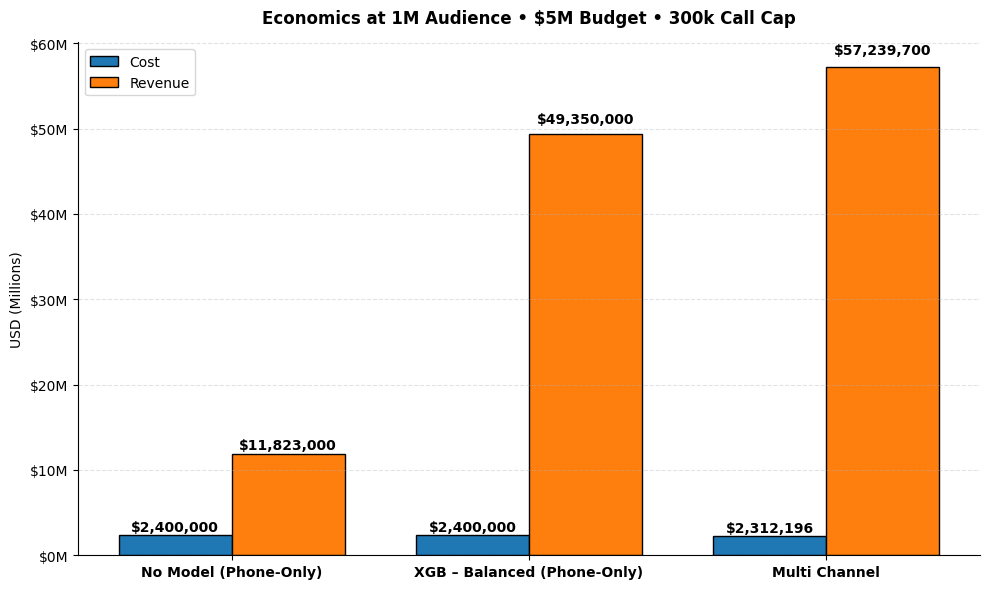

In [6]:
# Three-scenario comparison (No Model vs Balanced Phone-Only vs Multi-Channel w/ +10pp warm-call lift)
# Target audience = 1,000,000; Budget cap = $5M; Call-cap = 200k

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

# -------------------------
# Inputs / assumptions
# -------------------------
TARGET_AUDIENCE = 1_000_000
BUDGET          = 5_000_000.0
MAX_CALLS_CAP   = 300_000   # <-- 200k call capacity

CALL_COST       = 8.0
REV_PER_CONV    = 350.0

CR_NO_MODEL     = 0.1126    # cold-call conversion
CR_BALANCED     = 0.47      # model phone-only conversion
CR_MC_WARM      = min(1.0, CR_BALANCED + 0.10)  # +10 percentage points absolute lift → 0.57

# Multi-channel touch assumptions
ENG_RATE   = {"SMS": 0.28, "App Push": 0.025, "Email": 0.025}
TOUCH_COST = {"SMS": 0.01, "App Push": 0.01, "Email": 0.01}
SEQUENCE   = ["SMS", "App Push", "Email"]

# -------------------------
# Helper: channel presence from your df (top-3 by age bin)
# -------------------------
assert "age" in df.columns, "df must contain an 'age' column."

age_bins   = [-np.inf, 26, 42, 58, np.inf]
age_labels = ["<=26", "27-42", "43-58", "59+"]

top3_by_bin = {
    "<=26":  ["SMS", "App Push", "Internet Banking"],
    "27-42": ["SMS", "Internet Banking", "App Push"],
    "43-58": ["Internet Banking", "Email", "SMS"],
    "59+":   ["Internet Banking", "Direct Mail", "Email"]
}

df_channels_all = df[["age"]].copy()
df_channels_all["age_bin"] = pd.cut(df_channels_all["age"], bins=age_bins, labels=age_labels, right=True)
df_channels_all[["channel_1","channel_2","channel_3"]] = (
    df_channels_all["age_bin"].astype(str).map(top3_by_bin).apply(pd.Series)
)

def has_any(dfX, ch):
    return dfX[["channel_1","channel_2","channel_3"]].eq(ch).any(axis=1)

p_any = {
    "SMS":      has_any(df_channels_all, "SMS").mean(),
    "App Push": has_any(df_channels_all, "App Push").mean(),
    "Email":    has_any(df_channels_all, "Email").mean(),
}

# -------------------------
# Scenarios 1 & 2: Phone-only (No Model vs Balanced)
# -------------------------
calls_cap_budget = int(BUDGET // CALL_COST)
calls_cap = min(TARGET_AUDIENCE, calls_cap_budget, MAX_CALLS_CAP)

def phone_only_row(name, conv_rate):
    calls = calls_cap
    convs = int(round(calls * conv_rate))
    cost  = calls * CALL_COST
    rev   = convs * REV_PER_CONV
    net   = rev - cost
    roi   = rev / cost if cost > 0 else float("inf")
    return dict(Scenario=name, Calls=calls, Conversions=convs, Cost=cost, Revenue=rev, Net=net, ROI=roi)

row_no_model   = phone_only_row("No Model (Phone-Only)", CR_NO_MODEL)
row_balanced   = phone_only_row("XGB – Balanced (Phone-Only)", CR_BALANCED)

# -------------------------
# Scenario 3: Multi-channel (SMS → Push → Email; calls last, caps applied; +10pp warm-call lift)
# -------------------------
budget = BUDGET
remaining_pool = TARGET_AUDIENCE

def run_outreach(channel, remaining_pool, budget):
    prop = p_any[channel]
    eligible = int(round(remaining_pool * prop))
    if eligible <= 0 or budget <= 0:
        return 0, 0, 0.0, remaining_pool, budget
    unit = TOUCH_COST[channel]
    max_msgs_afford = int(budget // unit) if unit > 0 else eligible
    msgs_sent = min(eligible, max_msgs_afford)
    outreach_cost = msgs_sent * unit
    budget_after = budget - outreach_cost
    responders = int(np.floor(msgs_sent * ENG_RATE[channel]))
    remaining_after = max(0, remaining_pool - responders)
    return msgs_sent, responders, outreach_cost, remaining_after, budget_after

responders_total = 0
outreach_cost_total = 0.0
for ch in SEQUENCE:
    msgs_sent, responders, ocost, remaining_pool, budget = run_outreach(ch, remaining_pool, budget)
    responders_total += responders
    outreach_cost_total += ocost

# Calls last with caps (budget + call-center)
max_calls_by_budget = int(budget // CALL_COST)
call_cap_mc = min(MAX_CALLS_CAP, max_calls_by_budget)
calls_mc = min(responders_total, call_cap_mc)

phone_cost_mc = calls_mc * CALL_COST
budget_after_calls = budget - phone_cost_mc

convs_mc = int(round(calls_mc * CR_MC_WARM))
rev_mc   = convs_mc * REV_PER_CONV
cost_mc  = outreach_cost_total + phone_cost_mc
net_mc   = rev_mc - cost_mc
roi_mc   = rev_mc / cost_mc if cost_mc > 0 else float("inf")

row_multichannel = dict(
    Scenario="Multi Channel",
    Calls=calls_mc, Conversions=convs_mc,
    Cost=cost_mc, Revenue=rev_mc, Net=net_mc, ROI=roi_mc
)


# -------------------------
# Assemble table
# -------------------------
df_cmp = pd.DataFrame([row_no_model, row_balanced, row_multichannel])

display(
    df_cmp.style.format({
        "Calls":"{:,.0f}", "Conversions":"{:,.0f}",
        "Cost":"${:,.0f}", "Revenue":"${:,.0f}",
        "Net":"${:,.0f}", "ROI":"{:,.2f}x"
    }).set_properties(subset=["Scenario"], **{"font-weight":"bold"})
)

# -------------------------
# Plot: Cost vs Revenue, side-by-side, all-black labels
# -------------------------
fig, ax = plt.subplots(figsize=(10,6))

labels = df_cmp["Scenario"].tolist()
x = np.arange(len(labels))
w = 0.38

bars_cost = ax.bar(x - w/2, df_cmp["Cost"].values,  width=w, edgecolor="black", label="Cost")
bars_rev  = ax.bar(x + w/2, df_cmp["Revenue"].values, width=w, edgecolor="black", label="Revenue")

ax.yaxis.set_major_formatter(FuncFormatter(lambda v, _: f"${v/1e6:,.0f}M"))
ax.set_ylabel("USD (Millions)")
ax.set_xticks(x)
ax.set_xticklabels(labels, fontweight="bold")
ax.set_title("Economics at 1M Audience • $5M Budget • 300k Call Cap", fontweight="bold", pad=14)
ax.grid(axis="y", linestyle="--", alpha=0.35)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.legend(loc="upper left")

def label_bars(bars):
    for b in bars:
        h = b.get_height()
        ax.text(b.get_x() + b.get_width()/2, h*1.02, f"${h:,.0f}",
                ha="center", va="bottom", fontsize=10, fontweight="bold", color="black")

label_bars(bars_cost)
label_bars(bars_rev)

plt.tight_layout()
plt.show()


In [7]:
# Build an explanatory table for the plot with Conversion Rate (%) and ROI

# Map per-call conversion rate used in each scenario
cr_map = {
    "No Model (Phone-Only)": CR_NO_MODEL,
    "XGB – Balanced (Phone-Only)": CR_BALANCED,
    "Multi Channel": CR_MC_WARM,
    "Multi Channel (+10pp warm CR)": CR_MC_WARM,  # in case you kept the longer label
}

df_table = df_cmp.copy()

# Attach conversion rate by scenario name (fallback to NaN if label differs)
df_table["Conversion Rate (%)"] = df_table["Scenario"].map(cr_map).astype(float) * 100

# (Re)compute ROI defensively (Revenue / Cost)
df_table["ROI"] = df_table["Revenue"] / df_table["Cost"]

# Reorder columns for readability
cols = ["Scenario", "Calls", "Conversions", "Conversion Rate (%)", "Cost", "Revenue", "Net", "ROI"]
df_table = df_table[cols]

# Pretty print
display(
    df_table.style.format({
        "Calls": "{:,.0f}",
        "Conversions": "{:,.0f}",
        "Conversion Rate (%)": "{:,.2f}",
        "Cost": "${:,.0f}",
        "Revenue": "${:,.0f}",
        "Net": "${:,.0f}",
        "ROI": "{:,.2f}x",
    }).set_properties(subset=["Scenario"], **{"font-weight": "bold"})
)

,Scenario,Calls,Conversions,Conversion Rate (%),Cost,Revenue,Net,ROI
0,No Model (Phone-Only),"300,000","33,780",11.26,"$2,400,000","$11,823,000","$9,423,000",4.93x
1,XGB – Balanced (Phone-Only),"300,000","141,000",47.00,"$2,400,000","$49,350,000","$46,950,000",20.56x
2,Multi Channel,"286,916","163,542",57.00,"$2,312,196","$57,239,700","$54,927,504",24.76x


In [8]:
# Multi-channel flow table (SMS → App Push → Email), then calls last

# -------------------------
# Parameters
# -------------------------
TARGET_AUDIENCE = 1_000_000
BUDGET          = 5_000_000.0
CALL_CAP        = 300_000

CALL_COST       = 8.0
REV_PER_CONV    = 350.0

# Phone conversion for Multi Channel (e.g., Balanced 47% + 10pp warm uplift → 57%)
CR_BALANCED = 0.47
CR_MC_WARM  = 0.57   

# Touch economics
ENG_RATE   = {"SMS": 0.28, "App Push": 0.025, "Email": 0.025}
TOUCH_COST = {"SMS": 0.01, "App Push": 0.01, "Email": 0.01}
SEQUENCE   = ["SMS", "App Push", "Email"]

# -------------------------
# Build channel presence (top-3 by age bin) to estimate eligible volumes
# -------------------------
assert "age" in df.columns, "df must contain an 'age' column."

age_bins   = [-np.inf, 26, 42, 58, np.inf]
age_labels = ["<=26", "27-42", "43-58", "59+"]

top3_by_bin = {
    "<=26":  ["SMS", "App Push", "Internet Banking"],
    "27-42": ["SMS", "Internet Banking", "App Push"],
    "43-58": ["Internet Banking", "Email", "SMS"],
    "59+":   ["Internet Banking", "Direct Mail", "Email"]
}

df_ch = df[["age"]].copy()
df_ch["age_bin"] = pd.cut(df_ch["age"], bins=age_bins, labels=age_labels, right=True)
df_ch[["c1","c2","c3"]] = df_ch["age_bin"].astype(str).map(top3_by_bin).apply(pd.Series)

def has_any(dfX, ch): 
    return dfX[["c1","c2","c3"]].eq(ch).any(axis=1)

p_any = {
    "SMS":      has_any(df_ch, "SMS").mean(),
    "App Push": has_any(df_ch, "App Push").mean(),
    "Email":    has_any(df_ch, "Email").mean(),
}

# -------------------------
# Run sequential outreach (removing responders at each step)
# -------------------------
budget = BUDGET
remaining = TARGET_AUDIENCE
rows = []
responders_by_channel = {}

def run_step(channel, remaining_pool, budget_left):
    prop = p_any[channel]
    eligible = int(round(remaining_pool * prop))
    if eligible <= 0 or budget_left <= 0:
        return {
            "Channel": channel, "Eligible": 0, "Messages": 0,
            "Outreach Cost": 0.0, "Responders": 0,
            "Remaining After": remaining_pool, "Budget After": budget_left
        }
    unit = TOUCH_COST[channel]
    max_msgs = int(budget_left // unit) if unit > 0 else eligible
    msgs = min(eligible, max_msgs)
    ocost = msgs * unit
    budget_after = budget_left - ocost

    responders = int(np.floor(msgs * ENG_RATE[channel]))
    remaining_after = max(0, remaining_pool - responders)

    return {
        "Channel": channel,
        "Eligible": eligible,
        "Messages": msgs,
        "Outreach Cost": ocost,
        "Responders": responders,
        "Remaining After": remaining_after,
        "Budget After": budget_after
    }

for step_i, ch in enumerate(SEQUENCE, start=1):
    res = run_step(ch, remaining, budget)
    res["Stage"] = f"Step {step_i}"
    rows.append(res)
    budget = res["Budget After"]
    remaining = res["Remaining After"]
    responders_by_channel[ch] = res["Responders"]

df_flow = pd.DataFrame(rows, columns=["Stage","Channel","Eligible","Messages","Outreach Cost","Responders","Remaining After","Budget After"])

# -------------------------
# Calls last (budget + call-cap)
# -------------------------
total_responders = int(df_flow["Responders"].sum())
max_calls_by_budget = int(budget // CALL_COST)
calls_made = min(total_responders, CALL_CAP, max_calls_by_budget)

phone_cost = calls_made * CALL_COST
budget_after_calls = budget - phone_cost

conversions = int(round(calls_made * CR_MC_WARM))
revenue = conversions * REV_PER_CONV

total_outreach_cost = float(df_flow["Outreach Cost"].sum())
total_cost = total_outreach_cost + phone_cost
net_profit = revenue - total_cost
roi = revenue / total_cost if total_cost > 0 else float("inf")

# Attribution of calls & conversions to touchpoint (proportional to responders)
attrib = []
if total_responders > 0 and calls_made > 0:
    for ch in SEQUENCE:
        resp = responders_by_channel.get(ch, 0)
        share = resp / total_responders if total_responders else 0
        calls_ch = int(round(calls_made * share))
        convs_ch = int(round(conversions * share))
        attrib.append([ch, resp, calls_ch, convs_ch])

df_attrib = pd.DataFrame(attrib, columns=["Channel","Responders","Calls Made","Conversions"])

# -------------------------
# Pretty print tables
# -------------------------
def fmti(x): return f"{int(x):,}"
def fmtm(x): return f"${x:,.2f}"

df_flow_present = df_flow.assign(
    Eligible=df_flow["Eligible"].map(fmti),
    Messages=df_flow["Messages"].map(fmti),
    **{
        "Outreach Cost": df_flow["Outreach Cost"].map(fmtm),
        "Responders": df_flow["Responders"].map(fmti),
        "Remaining After": df_flow["Remaining After"].map(fmti),
        "Budget After": df_flow["Budget After"].map(fmtm),
    }
)

summary = pd.DataFrame([{
    "Stage": "Calls",
    "Channel": "Phone",
    "Eligible": fmti(total_responders),
    "Messages": fmti(calls_made),  # here "Messages" shows Calls
    "Outreach Cost": fmtm(total_outreach_cost),
    "Responders": fmti(total_responders),
    "Remaining After": fmti(remaining),
    "Budget After": fmtm(budget_after_calls),
}])

econ = pd.DataFrame([{
    "Calls Made": fmti(calls_made),
    "Phone Cost": fmtm(phone_cost),
    "Conversions": fmti(conversions),
    "Revenue": fmtm(revenue),
    "Total Cost (Outreach + Calls)": fmtm(total_cost),
    "Net Profit": fmtm(net_profit),
    "ROI": f"{(roi):.2f}x",
    "Budget Remaining": fmtm(budget_after_calls)
}])

print("=== Multi-Channel Flow (SMS → App Push → Email) ===")
display(df_flow_present)

print("\n=== Calls (Last) & Economics ===")
display(econ)

if not df_attrib.empty:
    print("\n=== Attribution of Calls & Conversions by Touchpoint ===")
    display(
        df_attrib.style.format({
            "Responders":"{:,.0f}",
            "Calls Made":"{:,.0f}",
            "Conversions":"{:,.0f}"
        })
    )


=== Multi-Channel Flow (SMS → App Push → Email) ===


,Stage,Channel,Eligible,Messages,Outreach Cost,Responders,Remaining After,Budget After
0,Step 1,SMS,"959,794","959,794","$9,597.94","268,742","731,258","$4,990,402.06"
1,Step 2,App Push,"464,946","464,946","$4,649.46","11,623","719,635","$4,985,752.60"
2,Step 3,Email,"262,079","262,079","$2,620.79","6,551","713,084","$4,983,131.81"



=== Calls (Last) & Economics ===


,Calls Made,Phone Cost,Conversions,Revenue,Total Cost (Outreach + Calls),Net Profit,ROI,Budget Remaining
0,"286,916","$2,295,328.00","163,542","$57,239,700.00","$2,312,196.19","$54,927,503.81",24.76x,"$2,687,803.81"



=== Attribution of Calls & Conversions by Touchpoint ===


,Channel,Responders,Calls Made,Conversions
0,SMS,"268,742","268,742","153,183"
1,App Push,"11,623","11,623","6,625"
2,Email,"6,551","6,551","3,734"


### Multi-Channel Campaign ROI Analysis

In this section, we simulated a multi-channel customer outreach campaign, starting from an initial SMS blast and progressively moving to lower-cost digital channels before using high-cost channels such as phone calls or physical mail. For each stage, we applied campaign rules to filter the remaining audience, updated eligible counts, and calculated outreach costs, conversions, and net profit. We factored in realistic per-contact costs for each channel, a fixed revenue-per-conversion value, and channel-specific drop-off patterns. This allowed us to track how budget was spent, measure the incremental lift from each step, and compare the ROI of different outreach sequences. The final output is a step-by-step breakdown of audience attrition, costs, revenues, and profitability, enabling data-driven optimization of channel order and budget allocation.